In [31]:
import math
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.image as mpimg

def gaussian_kernel():
    sigma1 = sigma2 = 1.4
    temp_sum = 0
    kernel = np.zeros([5, 5])
    for x in range(5):
        for y in range(5):
            kernel[x, y] = math.exp((-1 / (2*sigma1*sigma2)) * (np.square(x-3) 
                                + np.square(y-3))) / (2*math.pi*sigma1*sigma2)
            temp_sum += kernel[x, y]
                
    kernel /= temp_sum
    return kernel

In [45]:
# this function has been explicitly quoted in gaussian_filter function below
# do not quote this again!!!
class basic_operation:
    def __init__(self, img):
        self.img = img
        self.h, self.w = img.shape
        
    def mirror_padding(self):
        img_padding = np.zeros([self.h+4, self.w+4], np.uint8)

        img_padding[2:-2, 2:-2] = self.img[:, :]

        img_padding[0, 2:-2] = self.img[2, :]; img_padding[1, 2:-2] = self.img[1, :]
        img_padding[-1, 2:-2] = self.img[-3, :]; img_padding[-2, 2:-2] = self.img[-2, :]

        img_padding[2:-2, 0] = self.img[:, 2]; img_padding[2:-2, 1] = self.img[:, 1]
        img_padding[2:-2, -1] = self.img[:, -3]; img_padding[2:-2, -2] = self.img[:, -2]

        img_padding[0, 0] = self.img[2, 2]; img_padding[1, 1] = self.img[1, 1]; img_padding[1, 0] = self.img[1, 2]; img_padding[0, 1] = self.img[2, 1]
        img_padding[0, -1] = self.img[2, -3]; img_padding[1, -2] = self.img[1, -2]; img_padding[1, -1] = self.img[1, -3]; img_padding[0, -2] = self.img[2, -2]
        img_padding[-1, 0] = self.img[-3, 2]; img_padding[-2, 1] = self.img[-2, -2]; img_padding[-2, 0] = self.img[-2, 2]; img_padding[-1, 1] = self.img[-3, 1]
        img_padding[-1, -1] = self.img[-3, -3]; img_padding[-2, -2] = self.img[-2, -2]; img_padding[-2, -1] = self.img[-2, -3]; img_padding[-1, -2] = self.img[-3, -2]
        return img_padding

    def gaussian_filter(self, direction):
        kernel = gaussian_kernel()
        __img = self.mirror_padding(self.img)
        __h, __w = __img.shape 
        new_img = np.zeros([__h-4, __w-4])

        if direction == 'down': norm = 1
        if direction == 'up': norm = 4

        for x in range(2, __h-2):
            for y in range(2, __w-2):
#                 neibour = np.array([[img[i, j, :] for i in range(x-1, x+2)] for j in range(y-1, y+2)])
                temp = np.sum(__img[x-2:x+3, y-2:y+3]*kernel) * norm
                if temp<=255 and temp>=0: new_img[x-2, y-2] = temp
                elif temp<0: new_img[x-2, y-2] = 0
                elif temp>255: new_img[x-2, y-2] = 255
        return new_img

    def downsampling(self):
        hs = np.int(np.floor(self.h/2)); ws = np.int(np.floor(self.w/2))
        sampled_img = np.zeros([hs, ws])

        for x in range(self.h):
            for y in range(self.w):
                if x % 2 and y % 2: 
                    sampled_img[np.floor(x/2 - 0.5), np.floor(y/2 - 0.5)] = self.img[x, y]
        return sampled_img

    def upsampling(self):
        hs = self.h * 2; ws = self.w * 2
        sampled_img = np.zeros([hs, ws])

        for x in range(self.h):
            for y in range(self.w):
                sampled_img[2*x+1, 2*y+1] = img[x, y]
                sampled_img[2*x, 2*y], sampled_img[2*x, 2*y+1], sampled_img[2*x+1, 2*y] = 0, 0, 0
#                 sampled_img[2*x, 2*y] = self.img[x, y]
#                 sampled_img[2*x+1, 2*y+1], sampled_img[2*x, 2*y+1], sampled_img[2*x+1, 2*y] = 0, 0, 0
        return sampled_img

In [42]:
class operations(basic_operation):
    def __init__(self, img):
        basic_operation.__init__(self, img)
        
    def gaussian_down_pyramid(self, layers):
        pyimg = np.array([])
        down_py = {'layer0': self.img}
        for i in range(layers-1):
            if not i: 
                pyimg = downsampling(gaussian_filter(self.img, direction='down'))
            if i:
                pyimg = downsampling(gaussian_filter(pyimg, direction='down'))
            down_py['layer{}'.format(i+1)] = pyimg
        return down_py
    
    def gaussian_up_pyramid(self, layers):
        up_py = {}
        pyimg = np.array([])
        down_py = self.gaussian_down_pyramid(layers+1)
        for i in range(layers):
            pyimg = gaussian_filter(upsampling(down_py['layer{}'.format(i+1)]), direction='up')
            up_py['layer{}'.format(i)] = pyimg
        return down_py, up_py
        
    def laplacian_pyramid(self, layers):
        lap_py = {}
        lapimg = np.array([])
        down_py, up_py = self.gaussian_up_pyramid(layers)
        for l in range(layers):
            cuimg_d = down_py['layer{}'.format(l)]; cuimg_u = up_py['layer{}'.format(l)]
            hd, wd = cuimg_d.shape; hu, wu = cuimg_u.shape
            hmin = min(hd, hu); wmin = min(wd, wu)
            lapimg = np.subtract(cuimg_d[:hmin, :wmin], cuimg_u[:hmin, :wmin])
            np.clip(lapimg, 0, 255, out=lapimg)
            lap_py['layer' + str(l)] = lapimg
        return lap_py

finished


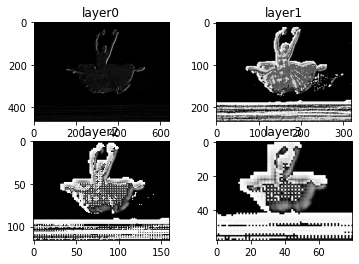

In [46]:
if __name__ == '__main__':
    test = mpimg.imread('./vishneva.jpeg')
    test = np.dot(test, [0.299, 0.587, 0.114])
    test = operations(test)
    lap_py = test.laplacian_pyramid(4)
#     down_, up_= test.gaussian_up_pyramid(4)
    pyplot.figure(num='lap')
    print('finished')
    for i in range(4):
        pyplot.subplot(2, 2, i+1)
        pyplot.title('layer{}'.format(i))
        pyplot.imshow(lap_py['layer{}'.format(i)], cmap='Greys_r')

In [47]:
# for i in range(4):
#     mpimg.imsave('./pyramid_pg/class{}.png'.format(i), lap_py['layer{}'.format(i)], cmap='gray')

[0 2 4]
